# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [11]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [12]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,565.4284,0.2807,-46.5297
TRXUSDT,79.6748,75.4779,0.0375,-4.1969
JASMYUSDT,453.8661,296.0277,0.1470,-157.8383
SOLUSDT,261.7091,279.1480,0.1386,17.4389
OMUSDT,535.6761,572.6145,0.2843,36.9384
ETHUSDT,264.2048,182.3192,0.0905,-81.8855
BBUSDT,46.3321,42.4322,0.0211,-3.8998
BNBUSDT,1.1490,0.9791,0.0005,-0.1700
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [15]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [16]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [17]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [18]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [19]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [20]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDTRXUSDT not retrieved
LDTRXUSDT


In [21]:
positions=positions.sort_index()

In [22]:
positions.index=pd.to_datetime(positions.index)

In [23]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [24]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [25]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [27]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [28]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [29]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [30]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [31]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

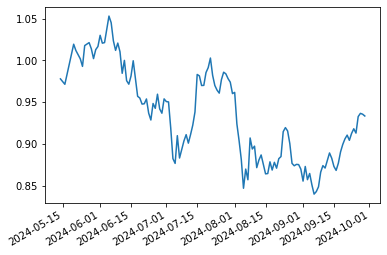

In [32]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [33]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [34]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [35]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [36]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9360
OMUSDT,0.0234
BNBUSDT,0.0163
TRXUSDT,0.0152
PEPEUSDT,0.0062
JASMYUSDT,0.0022
CKBUSDT,0.0006
STXUSDT,0.0000
ARUSDT,0.0000
FDUSDUSDT,0.0000


In [38]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.472718
BTCUSDT,0.400000
PEPEUSDT,0.098247
JASMYUSDT,0.014896
BNBUSDT,0.014139


In [39]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [40]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.755486
OMUSDT,0.244514


## Real Portfolio vs Optimal

In [41]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,572.614471,0.284257,0.244514,0.039743
BTCUSDT,565.428363,0.280689,0.000000,0.000000
JASMYUSDT,296.027748,0.146954,0.000000,0.000000
SOLUSDT,279.147984,0.138574,0.000000,0.000000
ETHUSDT,182.319239,0.090507,0.000000,0.000000
TRXUSDT,75.477888,0.037469,0.755486,-0.718017
BBUSDT,42.432245,0.021064,0.000000,0.000000
BNBUSDT,0.979090,0.000486,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [42]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,572.614471,0.284257,0.472718,-0.188461
BTCUSDT,565.428363,0.280689,0.400000,-0.119311
JASMYUSDT,296.027748,0.146954,0.014896,0.132058
SOLUSDT,279.147984,0.138574,0.000000,0.000000
ETHUSDT,182.319239,0.090507,0.000000,0.000000
TRXUSDT,75.477888,0.037469,0.000000,0.000000
BBUSDT,42.432245,0.021064,0.000000,0.000000
BNBUSDT,0.979090,0.000486,0.014139,-0.013653
PEPEUSDT,0.000003,0.000000,0.098247,-0.098247


# Risk Reward Analysis

In [43]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [44]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

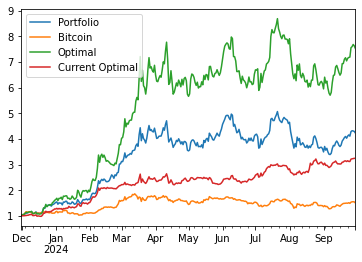

In [45]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [46]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

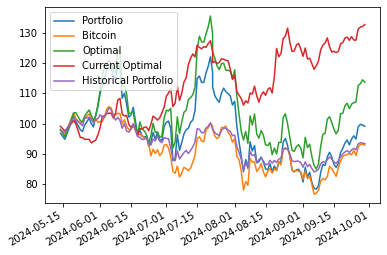

In [47]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [48]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-20,93.570719,89.561420,105.898328,128.312899,90.649751
2024-09-21,94.591121,89.770777,106.771336,128.621532,91.097867
2024-09-22,92.999258,90.095833,104.968803,127.558270,90.480102
2024-09-23,94.933946,89.756842,106.461526,128.784166,91.298984
2024-09-24,95.996577,91.054949,106.944801,127.670338,91.853987
2024-09-25,94.900409,89.467434,107.179264,127.616350,91.339446
2024-09-26,98.952226,92.287070,112.614645,131.336689,93.306318
2024-09-27,99.774647,93.127121,113.244847,131.904935,93.693252
2024-09-28,99.570023,93.251712,114.508709,132.181478,93.595109
2024-09-29,99.116517,92.888537,113.689036,132.776925,93.379558


## Volatilities

In [49]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.734979
dtype: float64

In [50]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.545315
dtype: float64

In [51]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.595463
Bitcoin            0.440764
Optimal            0.736154
Current Optimal    0.408094
dtype: float64

In [52]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2030734151232691

## Risk Contribution

In [53]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.016783,0.014139,0.002807,0.004032,0.000089,0.003943
BTCUSDT,0.202610,0.400000,0.054710,0.155576,0.057358,0.098218
JASMYUSDT,0.021053,0.014896,0.003264,0.008172,0.000479,0.007693
OMUSDT,9.490300,0.472718,0.904524,0.746368,0.647835,0.098534
PEPEUSDT,0.283909,0.098247,0.034695,0.085852,0.029481,0.056371


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.105031,0.244514,0.277028,0.457926,0.393432,0.064493
TRXUSDT,0.156738,0.755486,0.722972,0.542074,0.477581,0.064493


In [55]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.120274,0.28,0.370242,0.352703,0.190013,0.162690
BTCUSDT,-0.008692,0.28,0.250953,0.180693,0.044815,0.135877
JASMYUSDT,-0.003335,0.15,0.135661,0.215175,0.071054,0.144120
SOLUSDT,-0.008938,0.14,0.121228,0.141197,0.029171,0.112026
ETHUSDT,-0.015962,0.09,0.068483,0.070181,0.008026,0.062155
TRXUSDT,0.008299,0.04,0.044675,0.006357,0.000493,0.005864
BBUSDT,-0.010532,0.02,0.008757,0.033695,0.002696,0.030999


# Value At Risk

## Historical

In [56]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.061649559614568826, -0.08609616847443909)

In [57]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.051003966699306395, -0.0709849850141754)

In [58]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [59]:
var=historical_var.iloc[row]
var

OMUSDT      -0.007549
BTCUSDT     -0.015666
JASMYUSDT   -0.007218
SOLUSDT     -0.009521
ETHUSDT     -0.007823
TRXUSDT     -0.000926
BBUSDT      -0.002220
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050923
Name: 2024-08-27 00:00:00, dtype: float64

In [60]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.021927
BTCUSDT     -0.012905
JASMYUSDT   -0.014627
SOLUSDT     -0.010846
ETHUSDT     -0.005388
TRXUSDT     -0.000788
BBUSDT      -0.001997
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068477
dtype: float64

## Parametric

In [61]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07627734249435734, -0.09776646356057273)

In [62]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.056503365631677994, -0.07242169242442885)

## Multivariate

In [63]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06808608392967037, -0.08694235039417081)

In [64]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053669894775177945, -0.06752754730953209)

In [65]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.019173
BTCUSDT     -0.009420
JASMYUSDT   -0.012122
SOLUSDT     -0.008123
ETHUSDT     -0.003633
TRXUSDT     -0.000416
BBUSDT      -0.002030
Portfolio   -0.054916
dtype: float64

## Copulas

### Gaussian Copula

In [66]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07017936538132043, -0.08959125709468974)

In [67]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05459065751322273, -0.06859954868935515)

In [68]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.020783
BTCUSDT     -0.010100
JASMYUSDT   -0.010617
SOLUSDT     -0.007639
ETHUSDT     -0.003732
TRXUSDT     -0.000306
BBUSDT      -0.001743
Portfolio   -0.054920
dtype: float64

### Student Copula

In [69]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0692099217560652, -0.08888052960729748)

In [70]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05708186875334049, -0.07353780863742063)

In [71]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.019636
BTCUSDT     -0.010297
JASMYUSDT   -0.011961
SOLUSDT     -0.007899
ETHUSDT     -0.004039
TRXUSDT     -0.000435
BBUSDT      -0.001923
Portfolio   -0.056191
dtype: float64

### Gumbel Copula

In [72]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13491480742046433, -0.19061123094151497)

In [73]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0697367869451735, -0.09449430851749742)

In [74]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.037722
BTCUSDT     -0.006797
JASMYUSDT   -0.014175
SOLUSDT     -0.007706
ETHUSDT     -0.002195
TRXUSDT      0.000031
BBUSDT      -0.000371
Portfolio   -0.068934
dtype: float64

### Monte Carlo

In [75]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [76]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07804744100628296, -0.09735913279758028)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054986953703784966, -0.07009157431137626)

In [78]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.019271
BTCUSDT     -0.009936
JASMYUSDT   -0.013823
SOLUSDT     -0.007808
ETHUSDT     -0.004041
TRXUSDT     -0.000328
BBUSDT      -0.002291
Portfolio   -0.057498
dtype: float64

## VaR Violation

In [79]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.061468,-0.107972,-0.093339,-0.025934
2024-01-15,-0.061468,-0.107972,-0.093484,0.015515
2024-01-16,-0.061468,-0.108679,-0.089037,0.060610
2024-01-17,-0.061468,-0.110983,-0.097582,-0.035585
2024-01-18,-0.061468,-0.113119,-0.096569,-0.036344
...,...,...,...,...
2024-09-26,-0.041647,-0.071849,-0.064484,0.050713
2024-09-27,-0.041647,-0.071706,-0.062762,0.005596
2024-09-28,-0.041647,-0.071597,-0.062775,0.011160
2024-09-29,-0.041647,-0.071871,-0.064783,-0.007158


In [80]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031638,-0.085290,-0.077647,-0.017777
2024-05-29,-0.028927,-0.082375,-0.073808,-0.010068
2024-05-30,-0.028927,-0.071479,-0.063304,0.038500
2024-05-31,-0.028927,-0.070601,-0.062225,0.028058
2024-06-01,-0.028927,-0.071935,-0.061610,0.041604
...,...,...,...,...
2024-09-26,-0.025571,-0.050672,-0.042851,0.042695
2024-09-27,-0.025571,-0.048305,-0.040420,0.008311
2024-09-28,-0.025571,-0.048272,-0.041723,-0.002051
2024-09-29,-0.025552,-0.046476,-0.039051,-0.004555


<AxesSubplot:>

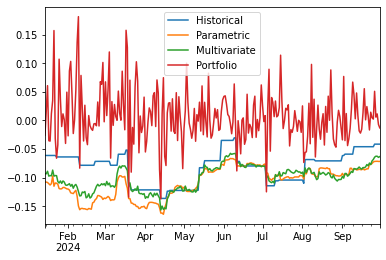

In [81]:
var_data.plot()

<AxesSubplot:>

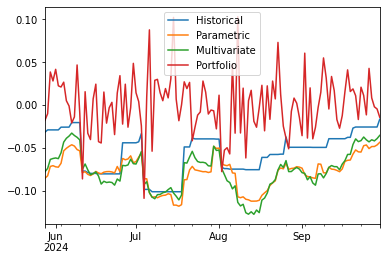

In [82]:
current_var_data.plot()

In [83]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022989,0.007663,0.011494
Kupiec Stat,4.974236,15.082728,11.6809
P-value,0.025728,0.000103,0.000631


In [84]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.055556,0.02381,0.02381
Kupiec Stat,0.079149,2.238529,2.238529
P-value,0.778454,0.134609,0.134609


## Principal Component Analysis

### Historical PCA

In [85]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78726586, 0.0668707 , 0.05475325, 0.0464777 , 0.04463248])

In [86]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014362
ADAUSDT     0.014697
ALGOUSDT    0.016243
APTUSDT     0.015643
ARBUSDT     0.015857
              ...   
WBTCUSDT    0.010235
WLDUSDT     0.021954
XLMUSDT     0.009758
XRPUSDT     0.009333
XTZUSDT     0.014780
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

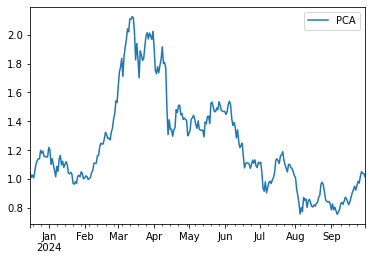

In [87]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

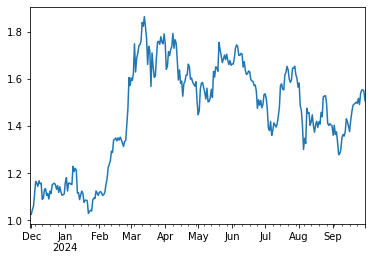

In [88]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [89]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.337768
ADAUSDT      0.341643
ALGOUSDT     0.347915
WBETHUSDT    0.354252
               ...   
PEPEUSDT     1.000751
FLOKIUSDT    1.009532
WLDUSDT      1.045509
CKBUSDT      1.153851
OMUSDT       1.314899
Length: 64, dtype: float64

<AxesSubplot:>

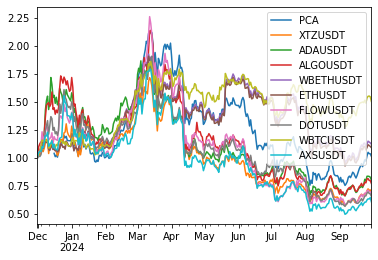

In [90]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

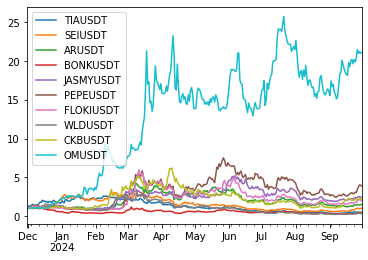

In [91]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [92]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66712989, 0.14090138, 0.08855071, 0.07107483, 0.03234319])

In [93]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.099539
BTCUSDT      0.064160
JASMYUSDT    0.154136
SOLUSDT      0.103789
ETHUSDT      0.086226
TRXUSDT      0.015315
BBUSDT       0.244389
BNBUSDT      0.068217
PEPEUSDT     0.164230
Name: PC1, dtype: float64

<AxesSubplot:>

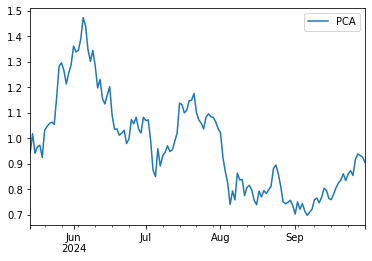

In [94]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

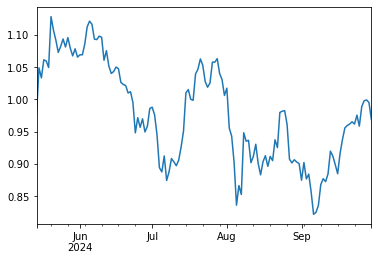

In [95]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [96]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.332722
SOLUSDT      0.344420
BTCUSDT      0.366119
BNBUSDT      0.366833
JASMYUSDT    0.426759
PEPEUSDT     0.472401
OMUSDT       0.540022
TRXUSDT      0.543427
BBUSDT       0.626301
dtype: float64

<AxesSubplot:>

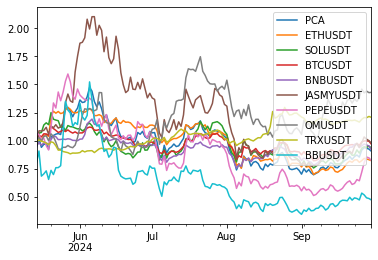

In [97]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [98]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.942338
BBUSDT       1.658839
JASMYUSDT    1.282605
SOLUSDT      1.164781
BTCUSDT      1.000000
OMUSDT       0.984693
ETHUSDT      0.952829
BNBUSDT      0.673978
TRXUSDT      0.280466
Name: BTCUSDT, dtype: float64

In [99]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.656695
BBUSDT       1.451738
JASMYUSDT    1.196417
BTCUSDT      1.000000
SOLUSDT      0.960492
BNBUSDT      0.950103
ETHUSDT      0.673679
OMUSDT       0.380864
TRXUSDT      0.271903
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [100]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.150844,0.000000,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.000000,0.111977,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.251896,0.000000,0.000000,0.000000,0.377064,0.000000,0.000000,0.000000,0.371040
